In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import warnings
import feather
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 22})

In [2]:
combined = pd.read_pickle("./data/combined.pkl")

In [5]:
inc_class = pd.read_csv("./data/wb_classification.csv", index_col=None).rename(columns={'country': 'wb'})
key = pd.read_csv("./data/country_key.csv")[['country', 'wb']]
inc_class = inc_class.merge(key, how="left", on="wb")

In [6]:
comb = combined.merge(inc_class[['class', 'country']], how="left", on="country")
comb['yield'] = comb['yield']/1000

In [7]:
hm = comb.groupby(['class', 'year', 'cropname'])[['yield', 'csif']].agg(
    yield_mean =('yield', 'mean'),
    csif=('csif', 'mean'),
    yield_35th=('yield', lambda x: x.quantile(0.35)),
    yield_65th=('yield', lambda x: x.quantile(0.65)),
    csif_35th=('csif', lambda x: x.quantile(0.35)),
    csif_65th=('csif', lambda x: x.quantile(0.65)),
    yield_std = ('yield', 'std'),
    csif_std = ('csif', 'std')
).reset_index()

hm = hm.rename(columns={'yield_mean':'yield'})

hm['yield_lower'] = hm['yield'] - hm['yield_std']/4
hm['yield_upper'] = hm['yield'] + hm['yield_std']/4
hm['csif_lower'] = hm['csif'] - hm['csif_std']/4
hm['csif_upper'] = hm['csif'] + hm['csif_std']/4

ugh= hm[(hm['cropname']=="Maize")]

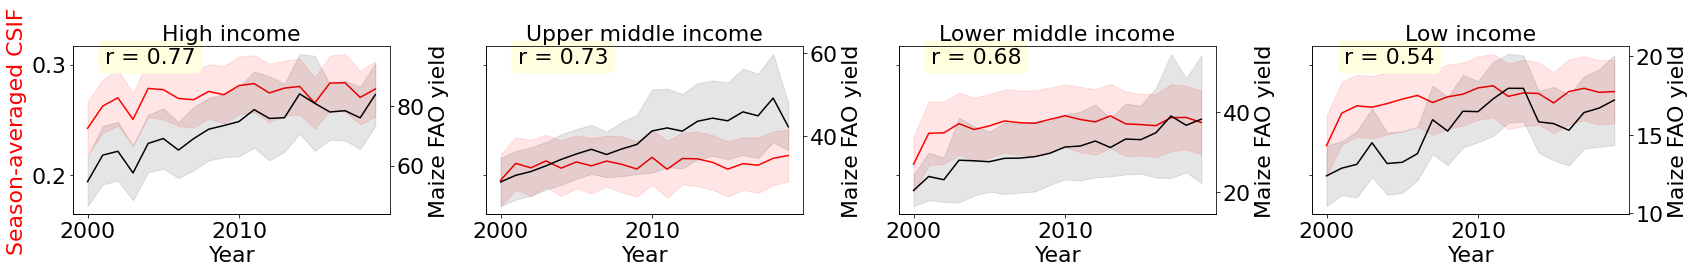

In [11]:
def twin_lineplot(data, x, y, color, **kwargs):
    ax = plt.gca().twinx()  # Create a twin y-axis
    sns.lineplot(data=data, x=x, y=y, color=color, ax=ax, **kwargs)
    ax.set_ylabel("Maize FAO yield", color=color)
    ax.tick_params(axis='y', colors=color)
    
    # Add ribbon for the 'yield' percentiles
    ax.fill_between(
        data[x], 
        data["yield_lower"], 
        data["yield_upper"], 
        color=color, 
        alpha=0.1
    )

# Create FacetGrid
g = sns.FacetGrid(ugh, col="class", height=4, aspect=1.5, col_order= ['High income', 'Upper middle income', 'Lower middle income', 'Low income'])

# Add CSIF line plot with ribbon
for ax, (_, data) in zip(g.axes.flat, ugh.groupby("class")):
    sns.lineplot(data=data, x="year", y="csif", color="red", ax=ax, ci=None)
    ax.set_ylabel("Season-averaged CSIF", color="red")
    ax.fill_between(
        data["year"], 
        data["csif_lower"], 
        data["csif_upper"], 
        color="red", 
        alpha=0.1
    )

# Add twin yield plot with ribbon
g.map_dataframe(twin_lineplot, x='year', y='yield', color="black")

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x,y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes,
               bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='lightyellow'))

g.map(corrfunc, "csif", "yield")

# Customize axis labels and titles
g.set_axis_labels("Year", "Season-averaged CSIF")
g.set_titles(col_template="{col_name}")

plt.show()
g.savefig("./plots/inc_class_ts.pdf")